In [1]:
import sys
sys.path.append('../../pyecog2')

In [2]:
from scipy.signal import stft

In [4]:
import numba

In [2]:
import json
from PyQt5 import QtCore
from PyQt5.QtCore import QObject
import numpy as np
from collections import OrderedDict
from h5loader import H5File
import glob, os
from datetime import datetime
from annotations_module import AnnotationPage

def create_metafile_from_h5(file):
    assert file.endswith('.h5')
    h5_file = H5File(file)
    fs_dict = eval(h5_file.attributes['fs_dict'])
    fs = fs_dict[int(h5_file.attributes['t_ids'][0])]
    for tid in h5_file.attributes['t_ids']:
        assert fs == int(fs_dict[tid])  # Check all tids have the same sampling rate
    metadata = OrderedDict(fs=fs,
                           no_channels=len(h5_file.attributes['t_ids']),
                           data_format='h5',
                           volts_per_bit=0,
                           transmitter_id=str(h5_file.attributes['t_ids']),
                           start_timestamp_unix=int(file.split('/')[-1].split('_')[0][1:]),
                           duration=3600,  # assume all h5 files have 1hr duration
                           channel_labels=[str(label) for label in h5_file.attributes['t_ids']],
                           experiment_metadata_str='')
    metafile = file[:-2] + 'meta'
    with open(metafile, 'w') as json_file:
        json.dump(metadata, json_file, indent=2, sort_keys=True)


class Animal():
    def __init__(self, id=None, eeg_folder=None, video_folder=None, dict={}):
        if dict != {}:
            self.__dict__ = dict
            self.annotations = AnnotationPage(dict = dict['annotations'])
            return

        if eeg_folder is not None:
            for file in glob.glob(eeg_folder + '/*.h5'):
                if os.path.isfile(file[:-2] + 'meta'):
                    print(file[:-2] + 'meta already exists')
                    continue
                create_metafile_from_h5(file)
            self.eeg_files = glob.glob(eeg_folder + '/*.meta')
            self.annotations = AnnotationPage()
            annotation_files = glob.glob(eeg_folder + '/*.anno')
            if annotation_files:
                self.annotations.import_from_json(annotation_files[0])
            self.eeg_init_time = [json.load(file)['start_timestamp_unix'] for file in map(open, self.eeg_files)]
            self.eeg_duration = [json.load(file)['duration'] for file in map(open, self.eeg_files)]
        else:
            self.eeg_files = []
            self.annotations = AnnotationPage()
            self.eeg_init_time = []
            self.eeg_duration = []

        if video_folder is not None:
            self.video_files = glob.glob(video_folder + '/*.mp4')
            self.video_init_time = [
                datetime(*map(int, [fname[-18:-14], fname[-14:-12], fname[-12:-10], fname[-10:-8], fname[-8:-6],
                                    fname[-6:-4]])).timestamp()
                for fname in self.video_files]
            self.video_duration = [15 * 60 for file in
                                   self.video_files]  # this should be replaced in the future to account flexible video durations
        else:
            self.video_files = []
            self.video_init_time = []
            self.video_duration = []

        if id is None and self.eeg_files:
            metadata = json.load(open(self.eeg_files[0]))
            self.id = metadata['transmitter_id']
        else:
            self.id = id

    def dict(self):
        dict = self.__dict__.copy()
        dict['annotations'] = self.annotations.dict()
        return dict

class file_buffer():  # Consider translating this to cython
    def __init__(self):
        self.files = []
        self.range = [np.Inf, -np.Inf]
        self.data = []
        self.data_ranges = []
        self.metadata = []

    def add_file_to_buffer(self, fname):
        if fname in self.files:  # skip if file is already buffered
            return
        else:
            self.files.append(fname)

        with open(fname, 'r') as json_file:
            metadata = json.load(json_file)
        self.metadata.append(metadata)

        if metadata['data_format'] == 'h5':
            h5file = H5File(fname[:-4] + 'h5')
            channels = []
            for tid in h5file.attributes['t_ids']:
                channels.append(h5file[tid]['data'])
            arr = np.vstack(channels).T
            self.data.append(arr)

        else:  # it is a bin file and can be mememaped
            m = np.memmap(fname[:4] + 'bin', mode='r+', shape=(-1, metadata['no_channels']))
            self.data.append(m)

        trange = [metadata['start_timestamp_unix'], metadata['start_timestamp_unix'] + metadata['duration']]
        self.data_ranges.append(trange)

        if self.range[0] > trange[0]:  # buffering earlier file
            self.range[0] = trange[0]
            if len(self.data) > 3:  # buffer 3 files - consider having this as a variable...
                i = max(range(len(self.data)),
                        key=lambda j: self.data_ranges[j][0])  # get the index of the latest starting buffered file
                del(self.files[i])
                del(self.data[i])
                del(self.data_ranges[i])
                del(self.metadata[i])
                self.range = [min([r[0] for r in self.data_ranges]), max([r[1] for r in self.data_ranges])]

        if self.range[1] < trange[1]:  # buffering later file
            self.range[1] = trange[1]
            if len(self.data) > 3:  # buffer 3 files - consider having this as a variable...
                i = min(range(len(self.data)),
                        key=lambda j: self.data_ranges[j][0])  # get the index of the earliest starting buffered file
                del(self.files[i])
                del(self.data[i])
                del(self.data_ranges[i])
                del(self.metadata[i])
                self.range = [min([r[0] for r in self.data_ranges]), max([r[1] for r in self.data_ranges])]

    def get_data_from_range(self, trange, channel=None, n_envelope=None):
        def clip(x, a, b):
            return min(max(int(x), a), b)

        #  Find sample ranges from data_ranges:
        sample_ranges = []
        print('range:',self.range)
        print('data ranges:',self.data_ranges)
        for i, ranges in enumerate(self.data_ranges):
            print('metadata',i,':',self.metadata[i])
            fs = self.metadata[i]['fs']
            print(((trange[0] - ranges[0]) * fs, 0, len(self.data[i])))
            sample_ranges.append([clip((trange[0] - ranges[0]) * fs, 0, len(self.data[i])),
                                  clip((trange[1] - ranges[0]) * fs, 0, len(self.data[i]))])

        total_sample_range = max(sum([s[1] - s[0] for s in sample_ranges]),1)
        if n_envelope is None:
            n_envelope = total_sample_range
        file_envlopes = [int(n_envelope * (s[1] - s[0]) / total_sample_range) +1  for s in
                             sample_ranges]  # distribute samples between files

        enveloped_data = []
        enveloped_time = []
        # print('sample ranges: ', sample_ranges)
        # print('data ranges: ', self.data_ranges)
        # print('data: ', len(self.data))
        for i, data in enumerate(self.data):
            start = sample_ranges[i][0]
            stop = sample_ranges[i][1]
            fs = self.metadata[i]['fs']

            # Decide by how much we should downsample
            ds = int((stop - start) / file_envlopes[i]) + 1
            if ds == 1:
                # Small enough to display with no intervention.
                if channel is None:
                    enveloped_data.append(data[start:stop, :])
                else:
                    enveloped_data.append(data[start:stop, channel].reshape(-1,1))

            else:
                # Here convert data into a down-sampled array suitable for visualizing.
                # Must do this piecewise to limit memory usage.
                samples = (1 + (stop - start) // ds)
                # print('grabbing',samples,'samples from buffred file',i)
                visible_data = np.zeros((samples * 2,1), dtype=data.dtype)
                sourcePtr = start
                targetPtr = 0
                try:
                    # read data in chunks of ~1M samples
                    chunkSize = int((1e6 // ds) * ds)
                    while sourcePtr < stop - 1:
                        chunk_data = data[sourcePtr:min(stop, sourcePtr + chunkSize), channel]
                        sourcePtr += chunkSize
                        # reshape chunk to be integer multiple of ds
                        chunk_data = chunk_data[:(len(chunk_data) // ds) * ds].reshape(len(chunk_data) // ds, ds)
                        mx_inds = np.argmax(chunk_data, axis=1)
                        mi_inds = np.argmin(chunk_data, axis=1)
                        row_inds = np.arange(chunk_data.shape[0])
                        chunkMax_x = chunk_data[row_inds, mx_inds].reshape(len(chunk_data),1)
                        chunkMin_x = chunk_data[row_inds, mi_inds].reshape(len(chunk_data),1)
                        visible_data[targetPtr:targetPtr + chunk_data.shape[0] * 2:2] = chunkMin_x
                        visible_data[1 + targetPtr:1 + targetPtr + chunk_data.shape[0] * 2:2] = chunkMax_x
                        targetPtr += chunk_data.shape[0] * 2

                    enveloped_data.append(visible_data[:targetPtr,:].reshape((-1,1)))

                except:
                    print('ERROR in downsampling')
                    raise
                    # throw_error()
                    # return 0

            enveloped_time.append(np.linspace(start/fs + self.data_ranges[i][0], stop/fs + self.data_ranges[i][0],
                                               len(enveloped_data[-1])).reshape(-1,1))
            if len(enveloped_time[-1])==0:
                del(enveloped_time[-1])
                del(enveloped_data[-1])
            # print('env data shapes')
            # print([data.shape for data in enveloped_data])
            # print([data.shape for data in enveloped_time])
        # sort vectors with enveloped_time:
        start_times = [(t[0], enveloped_data[i], t) for (i, t) in enumerate(enveloped_time)]
        start_times.sort()
        enveloped_data = [d[1] for d in start_times]
        enveloped_time = [d[2] for d in start_times]

        print('env data shapes')
        print([data.shape for data in enveloped_data])
        print([data.shape for data in enveloped_time])
        if len(enveloped_data)>0:
            data = np.vstack(enveloped_data)
            time = np.vstack(enveloped_time)
        else:
            data = np.array([0,0])
            time = np.array(trange)
        return data, time

class Project():
    def __init__(self, main_model, eeg_data_folder=None, video_data_folder=None, title='New Project', project_file='',dict=None):
        if dict is not None:
            self.__dict__ = dict
            self.animal_list = [Animal(dict = animal) for animal in dict['animal_list']]
            self.current_animal = Animal(dict = dict['current_animal'])
            self.main_model = main_model
            return
        self.main_model = main_model
        self.animal_list = []
        self.eeg_root_folder = eeg_data_folder
        self.video_root_folder = video_data_folder
        self.project_file = project_file
        self.title = title
        self.current_animal = Animal()  # start with empty animal
        self.file_buffer = file_buffer()

    def set_current_animal(self, animal): # copy alterations made to annotations
        self.current_animal.annotations.copy_from(self.main_model.annotations)
        self.main_model.annotations.copy_from(animal.annotations)
        self.current_animal = animal

    def save_to_json(self, fname):
        try:
            self.current_animal.annotations.copy_from(self.main_model.annotations) # save alterations made to the current animal annotations
        except:
            print('no main model defined')
        dict = self.__dict__.copy()
        del(dict['main_model'])
        dict['animal_list'] = [animal.dict() for animal in self.animal_list]  # make animals into dicts
        dict['current_animal'] = Animal().dict() # self.current_animal.dict() # Otherwise when loading the current animal would not be in the animal_list
        dict['file_buffer'] = None
        print(dict)
        json.dump(dict, open(fname, 'w'), indent=4)

    def load_from_json(self, fname):
        dict = json.load(open(fname))
        dict['animal_list'] = [Animal(dict=animal) for animal in dict['animal_list']]  # make dicts into animals
        dict['animal_list'].sort(key=lambda animal: animal.id)
        dict['current_animal'] = Animal(dict = dict['current_animal'])
        dict['file_buffer'] = file_buffer()
        main_model = self.main_model
        self.__dict__ = dict
        self.main_model = main_model

    def get_animal(self, animal_id):
        for animal in self.animal_list:
            if animal.id == animal_id:
                return animal
        return None  # return if animal not found

    def get_data_from_range(self, trange, channel=None, animal=None, n_envelope=None):
        '''
        :param trange: list of length 2 - [init_time, end_time] for the data to get
        :param channel: channel from wich to grab the data
        :param animal: animal object from which to get the data
        :param n_envelope: int - compute envelope in n_envelope number of points, if none, return all data
        :return:
        '''
        print('Project() get_data_from_range called for chanbel',channel,'; time range:', trange, ', duration:',trange[1]-trange[0])
        if (animal is not None) and (animal is not self.current_animal):  # reset file buffer if animal has changed
            print('Clearing File Buffer')
            self.current_animal = animal
            self.file_buffer = file_buffer()

        # First check if data is already buffered, most of the time this will be the case:
        if trange[0] >= self.file_buffer.range[0] and trange[1] <= self.file_buffer.range[1]:
            print('Data already in buffer')
            return self.file_buffer.get_data_from_range(trange,channel,n_envelope)

        # Now clear buffer if range is not contiguous to previous range
        if trange[1] <= self.file_buffer.range[0] or trange[0] >= self.file_buffer.range[1]:
            print('Non-contiguous data: restarting buffer...')
            self.file_buffer = file_buffer()

        for i, file in enumerate(self.current_animal.eeg_files):
            arange = [self.current_animal.eeg_init_time[i], self.current_animal.eeg_init_time[i] + self.current_animal.eeg_duration[i]]
            if (arange[0] <= trange[0] <= arange[1]) or (arange[0] <= trange[1] <= arange[1]) or\
                    (trange[0] <= arange[0] <= trange[1]) or (trange[0] <= arange[1] <= trange[1]):
                print('Adding file to buffer: ', file)
                self.file_buffer.add_file_to_buffer(file)
        print('files in buffer: ' , self.file_buffer.files)
        return self.file_buffer.get_data_from_range(trange, channel, n_envelope)



In [38]:
a = Animal(id = '119',eeg_folder='/home/mfpleite/Shared/ele_data/h5_119/',video_folder='/home/mfpleite/Shared/ele_data/119/')

/home/mfpleite/Shared/ele_data/h5_119/M1569833359_2019-09-30-09-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569844159_2019-09-30-12-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569815359_2019-09-30-04-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569880159_2019-09-30-22-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569811759_2019-09-30-03-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569822559_2019-09-30-06-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569858559_2019-09-30-16-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569872959_2019-09-30-20-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569836959_2019-09-30-10-49-19_tids_[119].meta already exists
/home/mfpleite/Shared/ele_data/h5_119/M1569865759_2019-09-30-18-49-19_tids_[119].meta alrea

In [39]:
a.eeg_files

['/home/mfpleite/Shared/ele_data/h5_119/M1569833359_2019-09-30-09-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569800959_2019-09-30-00-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569836959_2019-09-30-10-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569808159_2019-09-30-02-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569858559_2019-09-30-16-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569851359_2019-09-30-14-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569876559_2019-09-30-21-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569847759_2019-09-30-13-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569818959_2019-09-30-05-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569804559_2019-09-30-01-49-19_tids_[119].meta',
 '/home/mfpleite/Shared/ele_data/h5_119/M1569840559_2019-09-30-11-49-19_tids_[119].meta',
 '/home/mf

In [40]:
p = Project([])
p.animal_list =[a]

Annotations: invalid type for annotations list


In [41]:
b = p.get_animal('119')

In [42]:
type(b.annotations)

annotations_module.AnnotationPage

In [43]:
p.save_to_json('/home/mfpleite/Shared/ele_data/proj.pyecog')


no main model defined
Annotations: invalid type for annotations list
{'current_animal': {'video_files': [], 'eeg_files': [], 'annotations': {'annotations_list': [], 'focused_annotation': None, 'labels': [], 'label_color_dict': {}}, 'video_init_time': [], 'video_duration': [], 'eeg_init_time': [], 'id': None, 'eeg_duration': []}, 'project_file': '', 'title': 'New Project', 'animal_list': [{'video_files': ['/home/mfpleite/Shared/ele_data/119/20190923012407.mp4', '/home/mfpleite/Shared/ele_data/119/20190903065523.mp4', '/home/mfpleite/Shared/ele_data/119/20191018103919.mp4', '/home/mfpleite/Shared/ele_data/119/20190930150911.mp4', '/home/mfpleite/Shared/ele_data/119/20191018203919.mp4', '/home/mfpleite/Shared/ele_data/119/20190913040452.mp4', '/home/mfpleite/Shared/ele_data/119/20191019110920.mp4', '/home/mfpleite/Shared/ele_data/119/20190903161023.mp4'], 'eeg_files': ['/home/mfpleite/Shared/ele_data/h5_119/M1569833359_2019-09-30-09-49-19_tids_[119].meta', '/home/mfpleite/Shared/ele_data/

In [171]:
p.animal_list = []

In [36]:
p.load_from_json('/home/mfpleite/Shared/ele_data/proj.pyecog')

TypeError: __dict__ must be set to a dictionary, not a 'NoneType'

In [173]:
[a.__dict__ for a in p.animal_list]

[{'annotation_files': [],
  'eeg_duration': [3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600,
   3600],
  'eeg_files': ['/home/mfpleite/Shared/ele_data/h5_119/M1569833359_2019-09-30-09-49-19_tids_[119].meta',
   '/home/mfpleite/Shared/ele_data/h5_119/M1569800959_2019-09-30-00-49-19_tids_[119].meta',
   '/home/mfpleite/Shared/ele_data/h5_119/M1569836959_2019-09-30-10-49-19_tids_[119].meta',
   '/home/mfpleite/Shared/ele_data/h5_119/M1569808159_2019-09-30-02-49-19_tids_[119].meta',
   '/home/mfpleite/Shared/ele_data/h5_119/M1569858559_2019-09-30-16-49-19_tids_[119].meta',
   '/home/mfpleite/Shared/ele_data/h5_119/M1569851359_2019-09-30-14-49-19_tids_[119].meta',
   '/home/mfpleite/Shared/ele_data/h5_119/M1569876559_2019-09-30-21-49-19_tids_[119].meta',
   '/home/mfpleite/Shared/ele_data/h5_119/M1569847759_2019-09-30-13-49-19_tids_[119]

In [67]:
f = open('/home/mfpleite/Shared/ele_data/proj.pyecog','w')

TypeError: 'Animal' object is not iterable

In [59]:
a['t']

1

In [17]:

from PyQt5.QtMultimedia import QMediaContent, QMediaPlayer

In [20]:

qmc = QMediaContent(QUrl.fromLocalFile(a.video_files[0]))

In [19]:

from PyQt5.QtCore import QDir, Qt, QUrl
from PyQt5.QtWidgets import QMainWindow,QWidget, QPushButton, QAction

In [8]:

from PyQt5.QtCore import QDir, Qt, QUrl
from PyQt5.QtMultimedia import QMediaContent, QMediaPlayer

ImportError: No module named 'PyQt5.QtMultimedia'

In [23]:
qmc.request()

In [7]:
import os


In [58]:
os.path.join('/root_folder/folder','','test.nb',)

'/root_folder/folder/test.nb'

In [59]:
w =os.walk('/home/mfpleite/Shared/ele_data/')

In [60]:
w

<generator object walk at 0x7f7dd8af9d00>

In [41]:
wl = list(w)

In [44]:
wl

[('/home/mfpleite/Shared/ele_data/', ['h5_119', '119'], []),
 ('/home/mfpleite/Shared/ele_data/h5_119',
  ['test_folder'],
  ['M1569833359_2019-09-30-09-49-19_tids_[119].meta',
   'M1569800959_2019-09-30-00-49-19_tids_[119].meta',
   'M1569836959_2019-09-30-10-49-19_tids_[119].meta',
   'M1569833359_2019-09-30-09-49-19_tids_[119].h5',
   'M1569808159_2019-09-30-02-49-19_tids_[119].meta',
   'M1569844159_2019-09-30-12-49-19_tids_[119].h5',
   'M1569858559_2019-09-30-16-49-19_tids_[119].meta',
   'M1569815359_2019-09-30-04-49-19_tids_[119].h5',
   'M1569851359_2019-09-30-14-49-19_tids_[119].meta',
   'M1569876559_2019-09-30-21-49-19_tids_[119].meta',
   'M1569880159_2019-09-30-22-49-19_tids_[119].h5',
   'M1569847759_2019-09-30-13-49-19_tids_[119].meta',
   'M1569811759_2019-09-30-03-49-19_tids_[119].h5',
   'M1569818959_2019-09-30-05-49-19_tids_[119].meta',
   'M1569804559_2019-09-30-01-49-19_tids_[119].meta',
   'M1569822559_2019-09-30-06-49-19_tids_[119].h5',
   'M1569858559_2019-09-3

In [57]:
wl[2]

('/home/mfpleite/Shared/ele_data/h5_119/test_folder',
 [],
 ['M1569822559_2019-09-30-06-49-19_tids_[119].h5'])

In [1]:
a = {}

In [2]:
a=={}

True

In [5]:
a['b'] = 1

In [6]:
a

{'b': 1}

In [7]:
a

{'b': 1}

In [18]:
a.__dict__['annotation_files'] = ['test']

In [20]:
a.annotation_files

['test']

In [21]:
a

In [30]:
class Project():
    def __init__(self,eeg_data_folder=None,video_data_folder=None,title='New Project',dict={}):
        
        self.animal_list = []
        self.eeg_root_folder = eeg_data_folder
        self.video_root_folder = video_data_folder
        self.title = title


In [31]:
p = Project()

In [32]:
p.animal_list = [a]

In [43]:
p.__dict__.copy()

{'animal_list': [<__main__.Animal at 0x7fac5c3fb6d8>],
 'b': 2,
 'eeg_root_folder': None,
 'title': 'New Project',
 'video_root_folder': None}

In [46]:
d = p.__dict__

In [48]:
d['animal_list'] = [a.__dict__ for a in d['animal_list']]

In [49]:
d

{'animal_list': [{'annotation_files': ['test'],
   'eeg_duration': [1569833359,
    1569800959,
    1569836959,
    1569808159,
    1569858559,
    1569851359,
    1569876559,
    1569847759,
    1569818959,
    1569804559,
    1569840559,
    1569811759,
    1569869359,
    1569844159,
    1569854959,
    1569829759,
    1569883759,
    1569815359,
    1569822559,
    1569826159,
    1569880159,
    1569862159,
    1569872959,
    1569865759],
   'eeg_files': ['/home/mfpleite/Shared/ele_data/h5_119/M1569833359_2019-09-30-09-49-19_tids_[119].meta',
    '/home/mfpleite/Shared/ele_data/h5_119/M1569800959_2019-09-30-00-49-19_tids_[119].meta',
    '/home/mfpleite/Shared/ele_data/h5_119/M1569836959_2019-09-30-10-49-19_tids_[119].meta',
    '/home/mfpleite/Shared/ele_data/h5_119/M1569808159_2019-09-30-02-49-19_tids_[119].meta',
    '/home/mfpleite/Shared/ele_data/h5_119/M1569858559_2019-09-30-16-49-19_tids_[119].meta',
    '/home/mfpleite/Shared/ele_data/h5_119/M1569851359_2019-09-30-14-49-1

In [12]:
import numpy as np

In [27]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
b=a[:,0]

In [28]:
b

array([1, 4, 7])

In [29]:
a[0,0]=44

In [31]:
b

array([44,  4,  7])

In [32]:
b[0]=1
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [37]:
a = np.random.randn(100,10)

In [91]:
fp = np.memmap('test_np_memmap.bin', dtype='float32', mode='readwrite', shape=a.shape)


In [87]:
fp[:]=a[:]


In [109]:
b =fp

In [110]:
sys.getsizeof(b)

136

In [111]:
sys.getsizeof(a)

8112

In [103]:
import sys

In [127]:
s='abdcch5d.h5'

In [128]:
s.replace('.h5','.meta')

'abdcch5d.meta'

In [140]:
a = None

In [130]:
a

In [141]:
a is not None and a is not 4

False

In [174]:
def clip(x, a, b):
    min(max(x, a), b)

In [176]:
a =clip(1778235.7362060547, 0, 1843200)

In [178]:
min(max(1778235.7362060547, 0),

1778235.7362060547

0.8473785779788159


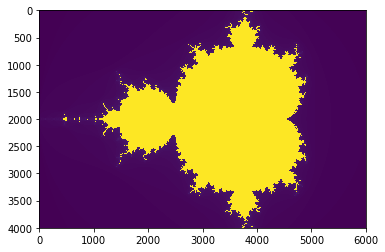

In [15]:
%matplotlib inline
k=8

from timeit import default_timer as timer
try:
    from matplotlib.pylab import imshow, show
    have_mpl = True
except ImportError:
    have_mpl = False
import numpy as np
from numba import jit

@jit(nopython=True)
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255

@jit(nopython=True)
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * k, 750 * k), dtype=np.uint8)
s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)
if have_mpl:
    imshow(image)

74.45428998599527


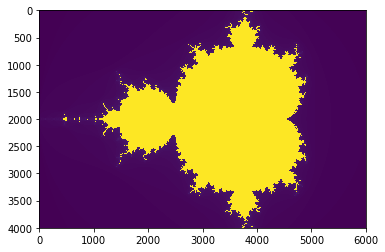

In [16]:

# @jit(nopython=True)
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255

# @jit(nopython=True)
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * k, 750 * k), dtype=np.uint8)
s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)
if have_mpl:
    imshow(image)

In [22]:
[ i for i in range(5) if i>2]

[3, 4]

In [24]:
type(None)

NoneType

In [26]:
str == type('asdsa')

True

In [3]:
a = [1,2,3]
b=[1,2,3]

In [4]:
a==b

True

In [1]:
148000/5


29600.0

In [2]:
29600/3600


8.222222222222221

In [1]:
import datetime

In [3]:
datetime.timezone()

TypeError: descriptor 'tzname' of 'datetime.timezone' object needs an argument

In [5]:
datetime.time.tzname()

TypeError: descriptor 'tzname' of 'datetime.time' object needs an argument